In [ ]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import (
    download_mnist_data,
    get_mnist_image_np_arrays,
    get_mnnist_labels_np_arrays,
    UMAPImageDataset,
)
from utils.autoencoder import MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder,
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

# Load MNIST images

In [3]:
# Skips downloading if data is already present
download_mnist_data()

Data is already downloaded. Skipping download.


In [4]:
train_images, test_images = get_mnist_image_np_arrays()

# Labels for visualization purposes
train_labels, test_labels = get_mnnist_labels_np_arrays()

# UMAP embeddings

## Generate  & save embeddings

In [49]:
# COMMENTED OUT TO AVOID REGENERATING UMAP EMBEDDINGS
# Remove comments to regenerate UMAP embeddings

embedding_dim = 256

full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
full_embeddings = reducer.fit_transform(flat_full_images)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

# Save full embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "mnist"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, full_embeddings)


## Load embeddings (if already saved)

In [62]:
embedding_dim = 2

project_dir = Path("..").resolve()
data_dir = project_dir / "data" / "mnist" / "umap_embeddings"
embeddings_file = data_dir / f"embeddings_d{embedding_dim}.npy"

full_embeddings = np.load(embeddings_file)
full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)

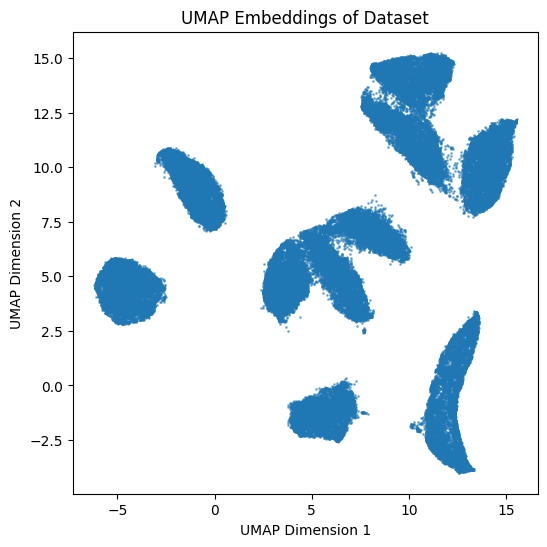

In [63]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(full_embeddings[:, 0], full_embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# Train Autoencoders

## Train & Test split

In [64]:
# Datasets
flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

flat_train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
flat_test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

flat_train_loader = torch.utils.data.DataLoader(
    flat_train_dataset, batch_size=128, shuffle=False
)
flat_test_loader = torch.utils.data.DataLoader(
    flat_test_dataset, batch_size=128, shuffle=False
)

## Train normal Autoencoder

In [65]:
autoencoder_input_dim = flat_full_images.shape[1]
normal_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)
normal_criterion = torch.nn.MSELoss()
normal_optimizer = torch.optim.Adam(normal_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

normal_num_epochs = 5

train_autoencoder(
    model=normal_autoencoder,
    dataloader=flat_train_loader,
    criterion=normal_criterion,
    optimizer=normal_optimizer,
    num_epochs=normal_num_epochs,
    device=device,
)

Epoch [1/5], Loss: 0.0561
Epoch [2/5], Loss: 0.0447
Epoch [3/5], Loss: 0.0424
Epoch [4/5], Loss: 0.0411
Epoch [5/5], Loss: 0.0402
Training complete.


## Train Autoencoder with UMAP as teacher

In [66]:
autoencoder_input_dim = flat_full_images.shape[1]
umap_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)

umap_criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
umap_optimizer = torch.optim.Adam(umap_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

umap_num_epochs = 10

train_autoencoder_with_umap(
    model=umap_autoencoder,
    dataloader=flat_train_loader,
    criterion=umap_criterion,
    optimizer=umap_optimizer,
    num_epochs=umap_num_epochs,
    device=device,
)


Epoch [1/10], Loss: 3.2915
Epoch [2/10], Loss: 0.9132
Epoch [3/10], Loss: 0.6104
Epoch [4/10], Loss: 0.4706
Epoch [5/10], Loss: 0.3799
Epoch [6/10], Loss: 0.3115
Epoch [7/10], Loss: 0.2610
Epoch [8/10], Loss: 0.2213
Epoch [9/10], Loss: 0.1925
Epoch [10/10], Loss: 0.1684
Training complete.


# Compare results

## Compare image results

### Plot normal Autoencoder results

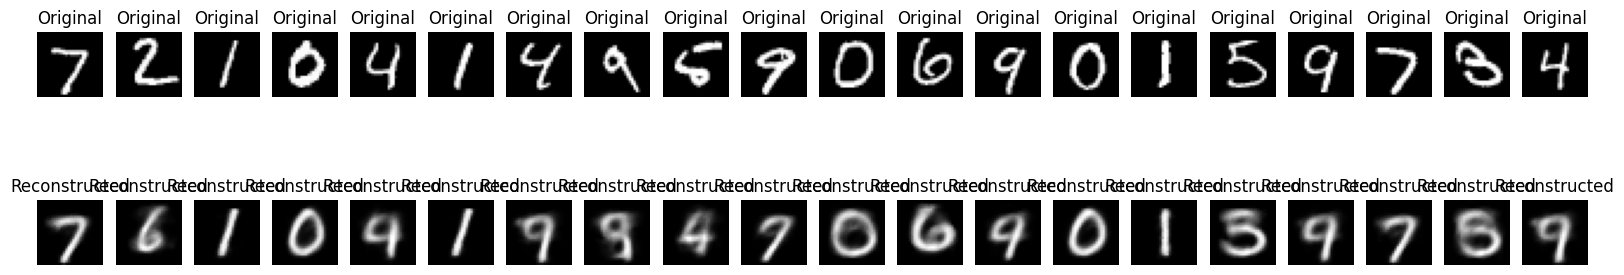

In [67]:
# Plot example image and reconstructions
normal_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = normal_autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

### Plot UMAP Autoecoder results

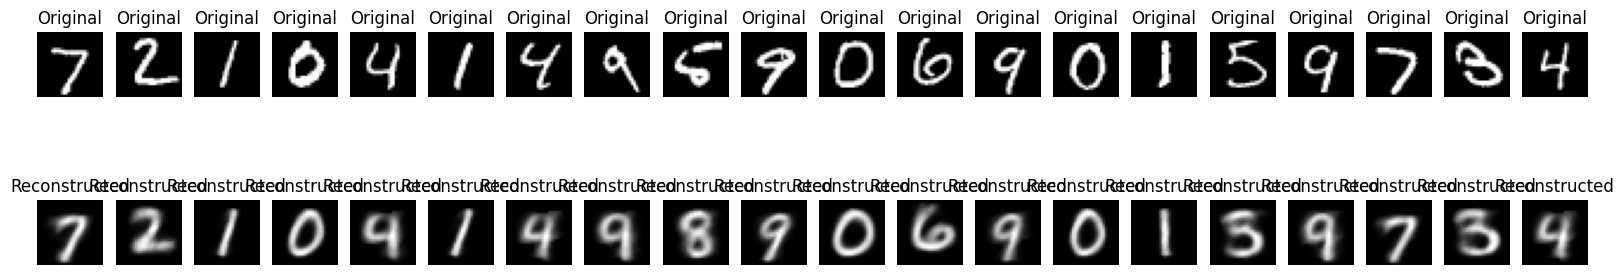

In [68]:
# Plot example image and reconstructions
umap_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = umap_autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

## Compare Metrics

In [69]:
# Test
normal_reconstruction_loss = test_autoencoder_reconstruction(
    normal_autoencoder, flat_test_loader, device
)
umap_reconstruction_loss = test_autoencoder_reconstruction(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder Reconstruction Loss: {normal_reconstruction_loss:.4f}")
print(f"UMAP Autoencoder Reconstruction Loss: {umap_reconstruction_loss:.4f}")

Normal Autoencoder Reconstruction Loss: 0.0403
UMAP Autoencoder Reconstruction Loss: 0.0432


In [70]:
normal_umap_embedding_loss = test_autoencoder_umap_embedding(
    normal_autoencoder, flat_test_loader, device
)
umap_umap_embedding_loss = test_autoencoder_umap_embedding(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder UMAP Embedding Loss: {normal_umap_embedding_loss:.4f}")
print(f"UMAP Autoencoder UMAP Embedding Loss: {umap_umap_embedding_loss:.4f}")

Normal Autoencoder UMAP Embedding Loss: 58.9470
UMAP Autoencoder UMAP Embedding Loss: 0.8586


## Compare latent spaces

### Normal Autoencoder latent space

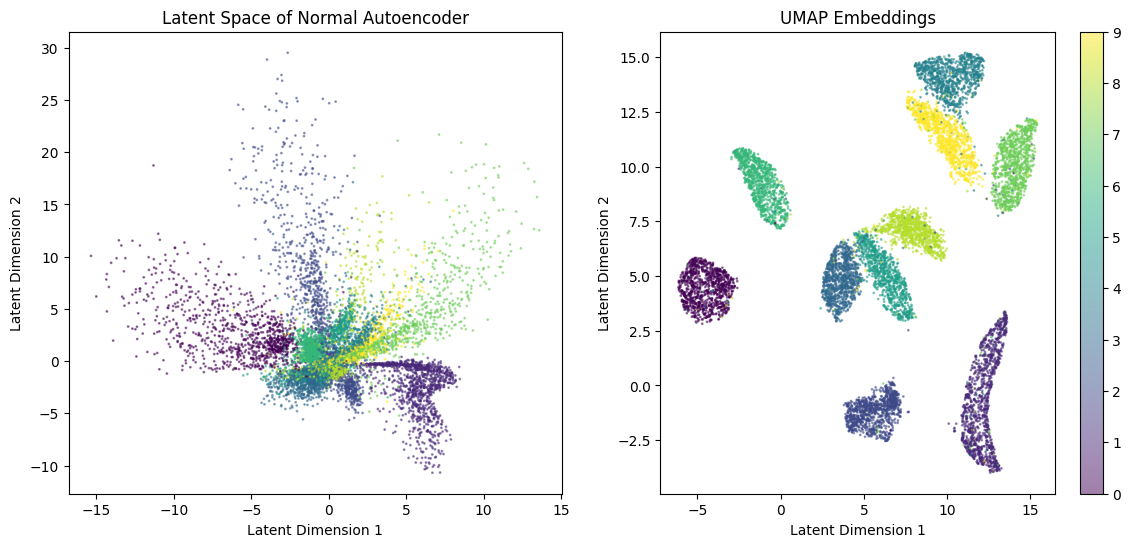

In [71]:
normal_autoencoder.eval()
all_latents = []
with torch.no_grad():
    for images, _ in flat_test_loader:
        images = images.to(device).float()
        latents = normal_autoencoder.encoder(images).cpu().numpy()
        all_latents.append(latents)
all_latents = np.concatenate(all_latents, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
colors = test_labels.argmax(axis=1)

ax[0].scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="Normal Autoencoder",
)

ax[1].scatter(
    test_embeddings[:, 0],
    test_embeddings[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="UMAP Embeddings",
)

ax[0].set_title("Latent Space of Normal Autoencoder")
ax[0].set_xlabel("Latent Dimension 1")
ax[0].set_ylabel("Latent Dimension 2")
ax[1].set_title("UMAP Embeddings")
ax[1].set_xlabel("Latent Dimension 1")
ax[1].set_ylabel("Latent Dimension 2")
plt.colorbar(ax[1].collections[0], ax=ax[1])
plt.show()

### UMAP Autoencoder latent space

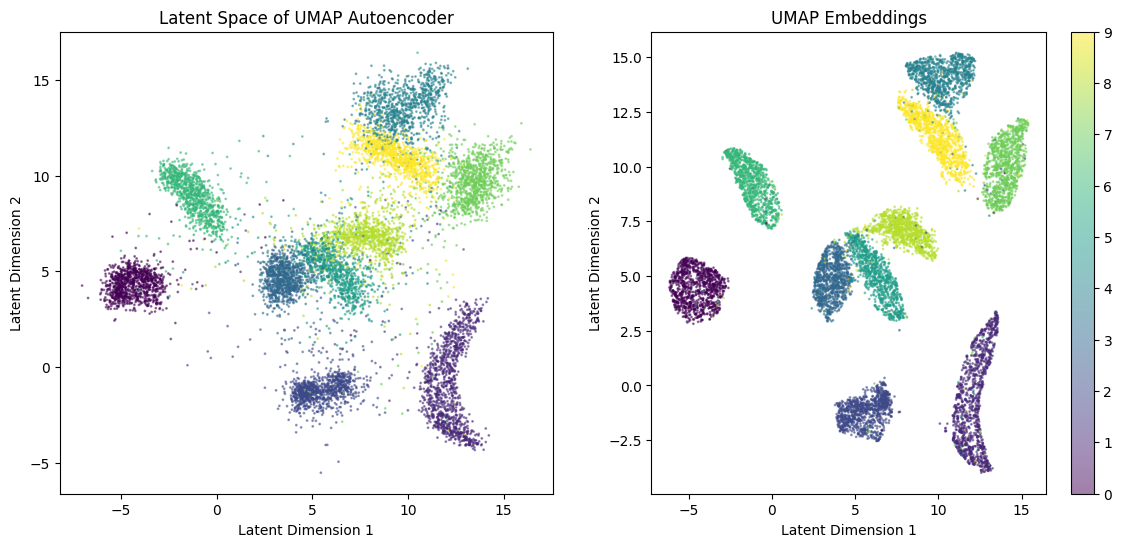

In [72]:
umap_autoencoder.eval()
all_latents = []
with torch.no_grad():
    for images, _ in flat_test_loader:
        images = images.to(device).float()
        latents = umap_autoencoder.encoder(images).cpu().numpy()
        all_latents.append(latents)
all_latents = np.concatenate(all_latents, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
colors = test_labels.argmax(axis=1)

ax[0].scatter(
    all_latents[:, 0],
    all_latents[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="Normal Autoencoder",
)

ax[1].scatter(
    test_embeddings[:, 0],
    test_embeddings[:, 1],
    s=1,
    alpha=0.5,
    c=colors,
    label="UMAP Embeddings",
)

ax[0].set_title("Latent Space of UMAP Autoencoder")
ax[0].set_xlabel("Latent Dimension 1")
ax[0].set_ylabel("Latent Dimension 2")
ax[1].set_title("UMAP Embeddings")
ax[1].set_xlabel("Latent Dimension 1")
ax[1].set_ylabel("Latent Dimension 2")
plt.colorbar(ax[1].collections[0], ax=ax[1])
plt.show()


# Recreate images from UMAP embedding

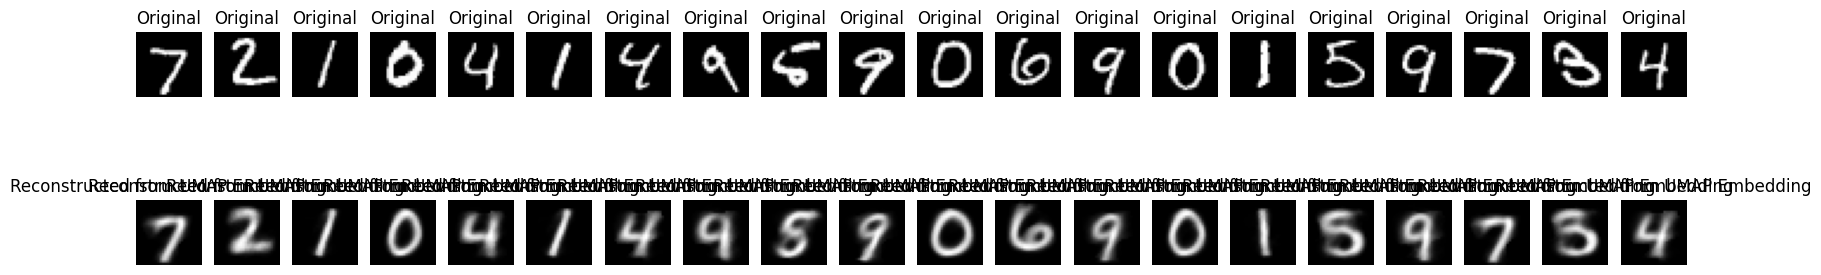

In [73]:
# pass all test UMAP embeddings through the UMAP decoder
reconstructed_test_images = (
    umap_autoencoder.decoder(
        torch.tensor(test_embeddings, dtype=torch.float32).to(device)
    )
    .cpu()
    .detach()
    .numpy()
)

# Plot some reconstructed images from UMAP embeddings
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed from UMAP embedding
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_test_images[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed from UMAP Embedding")
    plt.axis("off")
plt.show()